In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline
from scipy import exp
from datetime import datetime

In [24]:
# Simulation parameters
Settle = np.datetime64('2014-06-01')
Maturity = np.datetime64('2015-06-01')
Basis = 0
X0 = np.log(3.9)
Sigma = 0.59
NumTrials = 1000
NumPeriods = np.busday_count(Settle, Maturity)  # Approximate business days in the year
dt = 1 / NumPeriods
Kappa = 1.2
Theta = 1.7

# Time steps and random number generator for simulation
np.random.seed(0)
W = np.random.normal(0, np.sqrt(dt), (NumPeriods, NumTrials))  # Brownian increments

# Simulate the mean-reverting log price process (Ornstein-Uhlenbeck)
X = np.zeros((NumPeriods, NumTrials))
X[0] = X0

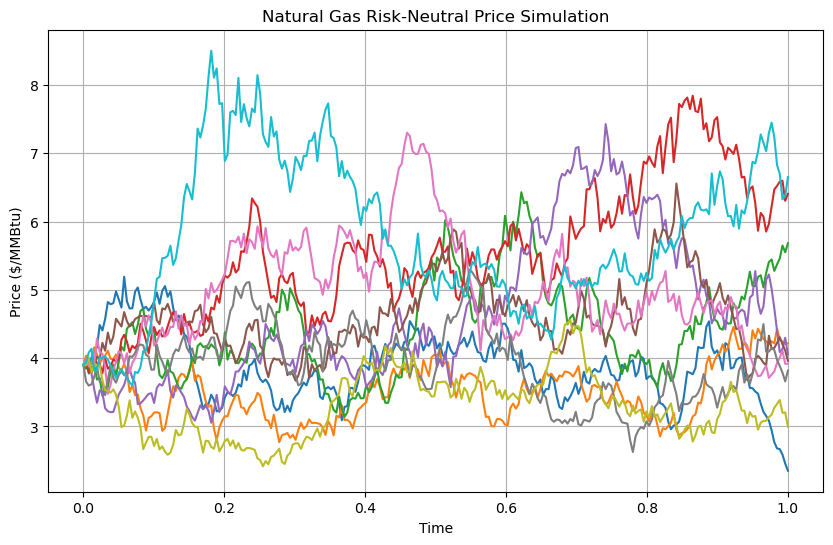

In [25]:
for t in range(1, NumPeriods):
    X[t] = X[t - 1] + Kappa * (Theta - X[t - 1]) * dt + Sigma * W[t]

# Convert log prices back to actual prices
Paths = np.exp(X)

# Plot simulated paths
plt.figure(figsize=(10, 6))
plt.plot(np.linspace(0, 1, NumPeriods), Paths[:, :10])  # Plot 10 paths for clarity
plt.title('Natural Gas Risk-Neutral Price Simulation')
plt.xlabel('Time')
plt.ylabel('Price ($/MMBtu)')
plt.grid(True)
plt.show()

In [27]:
# Interest rate term structure
rfrate = 0.01
DiscountFactors = np.exp(-rfrate * np.linspace(0, 1, NumPeriods))  # Flat rate over periods
# Swing option parameters
NumSwings = 5
DCQ = 10000
minDCQ = 2500
maxDCQ = 15000
Strike = 4.69

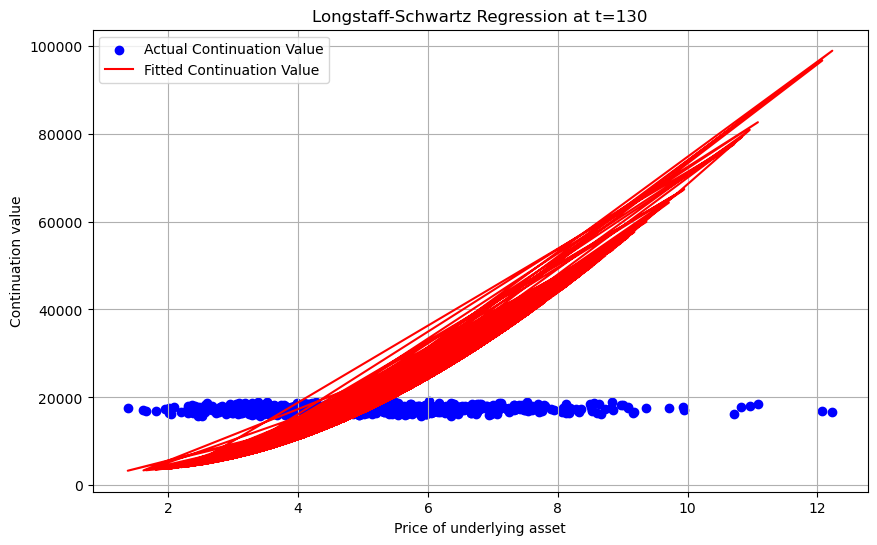

Swing Option Price (3rd-order polynomial): 2895.635679784678


In [34]:
from scipy.interpolate import UnivariateSpline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

def longstaff_schwartz(S, Times, RateSpec, Strike, NumSwings, DCQ, minDCQ, maxDCQ, smoothingParam=0.7):
    NumPeriods, NumTrials = S.shape
    U = np.zeros((NumSwings + 1, NumTrials))
    
    # Terminal payoff: max(DCQ-minDCQ, 0) * payoff at maturity
    U[NumSwings] = np.maximum(S[-1] - Strike, 0) * (maxDCQ - minDCQ)

    # Choose a specific time step to visualize the regression (e.g., the midpoint)
    time_to_plot = NumPeriods // 2
    X_to_plot = None
    continuation_value_hat_to_plot = None
    
    for t in range(NumPeriods - 2, -1, -1):
        discount = np.exp(-rfrate * (Times[t + 1] - Times[t]))
        continuation_value = discount * U[NumSwings]
        
        # Polynomial regression or spline
        X = S[t]
        Y = continuation_value
        
        poly = PolynomialFeatures(degree=3)
        X_poly = poly.fit_transform(X.reshape(-1, 1))
        reg = LinearRegression().fit(X_poly, Y)
        continuation_value_hat = reg.predict(X_poly)
        
        # Immediate exercise value
        immediate_value = np.maximum(S[t] - Strike, 0) * (maxDCQ - minDCQ)
        
        # Update option value based on whether to exercise or continue
        U[NumSwings] = np.maximum(immediate_value, continuation_value_hat)
    
    # Save data for plotting at the chosen time step
        if t == time_to_plot:
            X_to_plot = X
            continuation_value_hat_to_plot = continuation_value_hat

    # Plot the regression at the chosen time step
    plt.figure(figsize=(10, 6))
    plt.scatter(X_to_plot, Y, color='blue', label='Actual Continuation Value')
    plt.plot(X_to_plot, continuation_value_hat_to_plot, color='red', label='Fitted Continuation Value')
    plt.title(f'Longstaff-Schwartz Regression at t={time_to_plot}')
    plt.xlabel('Price of underlying asset')
    plt.ylabel('Continuation value')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return U

# Execute the Longstaff-Schwartz pricing
SwingPrice = longstaff_schwartz(Paths, np.linspace(0, 1, NumPeriods), DiscountFactors, Strike, NumSwings, DCQ, minDCQ, maxDCQ)
print("Swing Option Price (3rd-order polynomial):", np.mean(SwingPrice))



In [30]:
# Baseload price
BaseLoadPrice = DCQ * np.mean(Paths[1:] - Strike, axis=1).dot(DiscountFactors[1:])
FullContractPrice = BaseLoadPrice + np.mean(SwingPrice)

print(f"BaseLoad Price: {BaseLoadPrice:.2f}")
print(f"Full Contract Price: {FullContractPrice:.2f}")

BaseLoad Price: 154152.81
Full Contract Price: 157048.44


In [32]:
# Lower bound (European strip)
putEuro = DiscountFactors[-NumSwings:].dot(np.mean(np.maximum(Strike - Paths[-NumSwings:], 0), axis=1))
callEuro = DiscountFactors[-NumSwings:].dot(np.mean(np.maximum(Paths[-NumSwings:] - Strike, 0), axis=1))
lowerBound = ((DCQ - minDCQ) * putEuro + (maxDCQ - DCQ) * callEuro)

# Print comparison
print(f"Lower bound (European): {lowerBound:.2f}")
print(f"Swing Option Price: {np.mean(SwingPrice):.2f}")

Lower bound (European): 41246.26
Swing Option Price: 2895.64
